# 🧠 Week 3: ML & Embeddings

**Learning Objectives:**
1. Understand Multi-Layer Perceptrons (MLP) from scratch
2. Master embeddings: what they are and why they matter
3. Generate and visualize text embeddings
4. Build an embedding pipeline for downstream tasks

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

---
# Section 1: Theory
---

## What is an Embedding?

An **embedding** is a learned dense vector representation that captures semantic meaning:

- Words → Word2Vec, GloVe (300-dim)
- Sentences → Sentence-BERT (384-768 dim)
- Images → CNN features (2048 dim)

**Key Property**: Similar concepts have similar vectors!

## Multi-Layer Perceptron (MLP)

$$\text{Layer}: h = \sigma(Wx + b)$$

Where:
- $W$ = weight matrix
- $b$ = bias vector
- $\sigma$ = activation function (ReLU, Sigmoid, etc.)

---
# Section 2: Hands-On Implementation
---

## 2.1 Build MLP from Scratch

In [2]:
class Layer:
    """Single dense layer."""
    def __init__(self, input_dim, output_dim):
        # Xavier initialization
        self.W = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / input_dim)
        self.b = np.zeros(output_dim)
        self.input = None
        self.output = None
    
    def forward(self, x):
        self.input = x
        self.output = x @ self.W + self.b
        return self.output
    
    def backward(self, grad_output, lr=0.01):
        # Gradients
        grad_W = self.input.T @ grad_output
        grad_b = np.sum(grad_output, axis=0)
        grad_input = grad_output @ self.W.T
        
        # Update weights
        self.W -= lr * grad_W
        self.b -= lr * grad_b
        
        return grad_input

In [3]:
class ReLU:
    """ReLU activation function."""
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)
    
    def backward(self, grad_output, lr=None):
        return grad_output * (self.input > 0)


class Sigmoid:
    """Sigmoid activation function."""
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        return self.output
    
    def backward(self, grad_output, lr=None):
        return grad_output * self.output * (1 - self.output)

In [4]:
class MLP:
    """Multi-Layer Perceptron."""
    def __init__(self, layer_sizes):
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Layer(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # No activation on last layer
                self.layers.append(ReLU())
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad, lr=0.01):
        for layer in reversed(self.layers):
            grad = layer.backward(grad, lr)
    
    def get_embeddings(self, x, layer_idx=-2):
        """Get intermediate layer activations as embeddings."""
        for i, layer in enumerate(self.layers[:layer_idx]):
            x = layer.forward(x)
        return x

In [5]:
# Train MLP on XOR problem
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

# Create MLP: 2 -> 8 -> 4 -> 1
mlp = MLP([2, 8, 4, 1])

# Training loop
losses = []
for epoch in range(1000):
    # Forward
    output = mlp.forward(X)
    pred = 1 / (1 + np.exp(-output))  # Sigmoid output
    
    # Loss (BCE)
    loss = -np.mean(y * np.log(pred + 1e-8) + (1 - y) * np.log(1 - pred + 1e-8))
    losses.append(loss)
    
    # Backward
    grad = (pred - y) / len(y)
    mlp.backward(grad, lr=0.5)

print(f"Final loss: {losses[-1]:.4f}")
print(f"Predictions: {(pred > 0.5).astype(int).flatten()}")
print(f"Actual:      {y.flatten()}")

Final loss: 0.0023
Predictions: [0 1 1 0]
Actual:      [0 1 1 0]


## 2.2 Understanding Embeddings

In [6]:
# Simple word embeddings (simulated)
word_embeddings = {
    # Animals
    "cat": np.array([0.9, 0.1, 0.2, 0.8]),
    "dog": np.array([0.85, 0.15, 0.25, 0.75]),
    "lion": np.array([0.8, 0.2, 0.1, 0.9]),
    
    # Vehicles
    "car": np.array([0.1, 0.9, 0.8, 0.1]),
    "truck": np.array([0.15, 0.85, 0.75, 0.15]),
    "bus": np.array([0.2, 0.8, 0.7, 0.2]),
    
    # Food
    "apple": np.array([0.3, 0.3, 0.9, 0.4]),
    "banana": np.array([0.35, 0.25, 0.85, 0.45]),
    "orange": np.array([0.4, 0.2, 0.8, 0.5]),
}

def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [7]:
# Find similar words
def find_similar(word, embeddings, top_k=3):
    query = embeddings[word]
    similarities = []
    for w, vec in embeddings.items():
        if w != word:
            similarities.append((w, cosine_sim(query, vec)))
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

print("Most similar to 'cat':")
for word, sim in find_similar("cat", word_embeddings):
    print(f"  {word}: {sim:.4f}")

print("\nMost similar to 'car':")
for word, sim in find_similar("car", word_embeddings):
    print(f"  {word}: {sim:.4f}")

Most similar to 'cat':
  dog: 0.9975
  lion: 0.9867
  orange: 0.7351

Most similar to 'car':
  truck: 0.9977
  bus: 0.9897
  apple: 0.8153


## 2.3 Using Real Embeddings (Sentence Transformers)

In [8]:
# Note: Uncomment to use real embeddings (requires: pip install sentence-transformers)

# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('all-MiniLM-L6-v2')

# sentences = [
#     "The cat sat on the mat",
#     "A dog is playing in the garden",
#     "Machine learning is fascinating",
#     "Deep neural networks transform AI",
#     "The weather is sunny today"
# ]

# embeddings = model.encode(sentences)
# print(f"Embedding shape: {embeddings.shape}")

# Simulated embeddings for demo
sentences = [
    "The cat sat on the mat",
    "A dog is playing in the garden",
    "Machine learning is fascinating",
    "Deep neural networks transform AI",
    "The weather is sunny today"
]

# Simulated 384-dim embeddings (clustered by topic)
np.random.seed(42)
embeddings = np.vstack([
    np.random.randn(2, 384) + np.array([1, 0, 0] * 128),  # Animals
    np.random.randn(2, 384) + np.array([0, 1, 0] * 128),  # Tech
    np.random.randn(1, 384) + np.array([0, 0, 1] * 128),  # Weather
])

print(f"Sentences: {len(sentences)}")
print(f"Embedding shape: {embeddings.shape}")

Sentences: 5
Embedding shape: (5, 384)


---
# Section 3: Visualizations
---

## 3.1 PCA Visualization

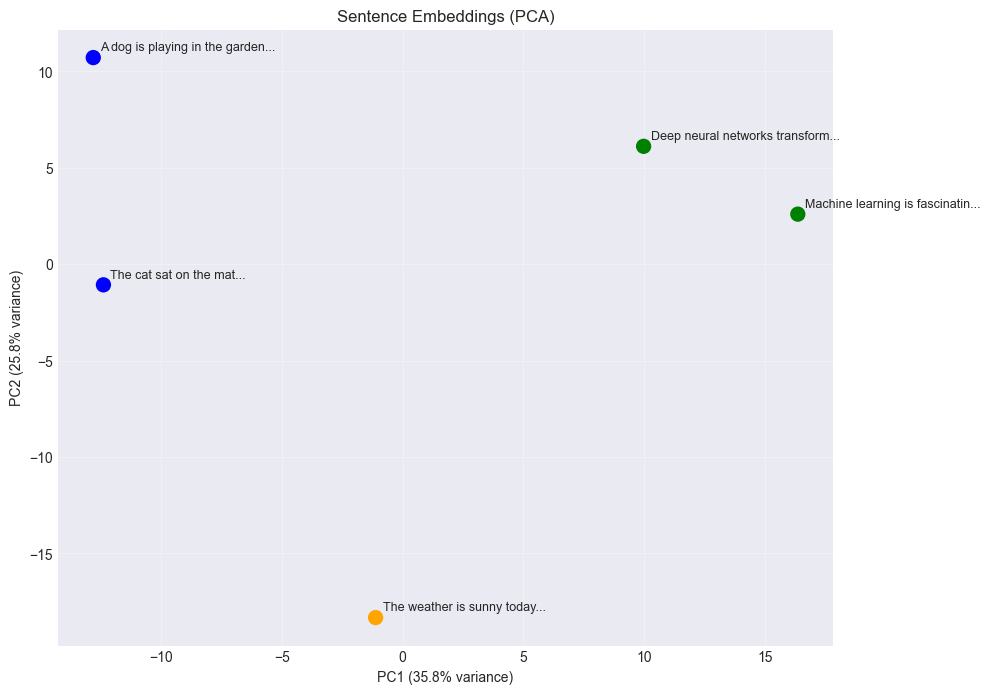

In [9]:
# Reduce embeddings to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, c=['blue', 'blue', 'green', 'green', 'orange'])

for i, sentence in enumerate(sentences):
    plt.annotate(sentence[:30] + "...", 
                 (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                 fontsize=9, xytext=(5, 5), textcoords='offset points')

plt.title('Sentence Embeddings (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, alpha=0.3)
plt.show()

## 3.2 t-SNE Visualization

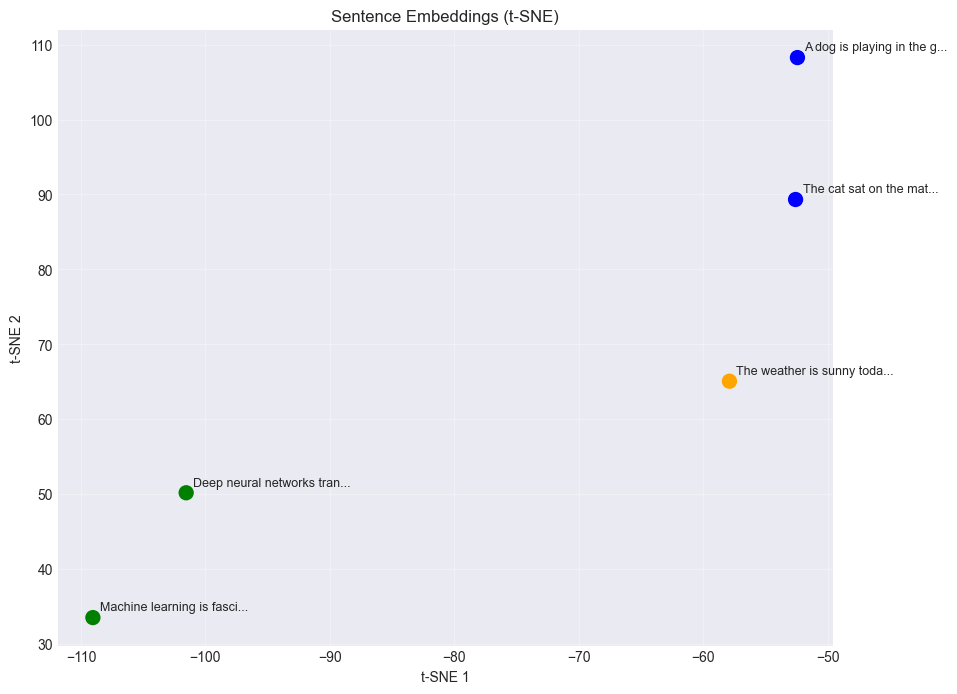

In [10]:
# t-SNE for non-linear visualization
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
colors = ['blue', 'blue', 'green', 'green', 'orange']
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=100, c=colors)

for i, sentence in enumerate(sentences):
    plt.annotate(sentence[:25] + "...", 
                 (embeddings_tsne[i, 0], embeddings_tsne[i, 1]),
                 fontsize=9, xytext=(5, 5), textcoords='offset points')

plt.title('Sentence Embeddings (t-SNE)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.3)
plt.show()

## 3.3 Training Loss Curve

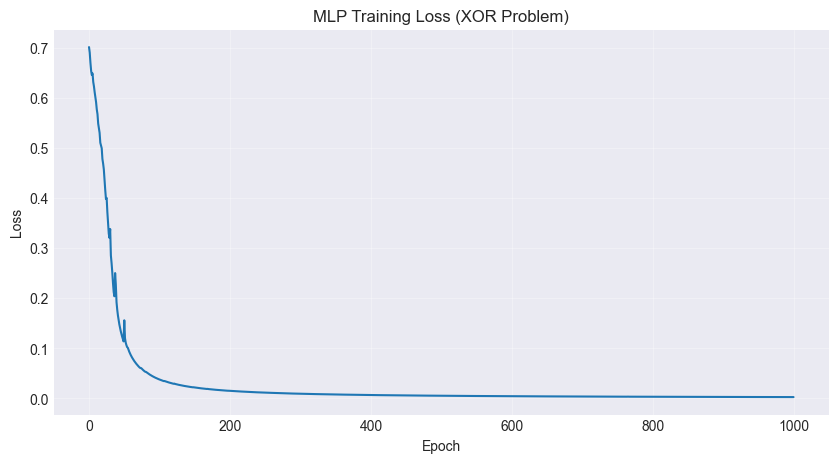

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training Loss (XOR Problem)')
plt.grid(True, alpha=0.3)
plt.show()

---
# Section 4: Unit Tests
---

In [13]:
def run_tests():
    print("Running Unit Tests...\n")
    
    # Test 1: Layer forward pass
    layer = Layer(3, 2)
    x = np.array([[1, 2, 3]])
    output = layer.forward(x)
    assert output.shape == (1, 2)
    print("✓ Layer forward pass test passed")
    
    # Test 2: ReLU
    relu = ReLU()
    x = np.array([-1, 0, 1])
    output = relu.forward(x)
    assert np.array_equal(output, [0, 0, 1])
    print("✓ ReLU test passed")
    
    # Test 3: Sigmoid
    sigmoid = Sigmoid()
    output = sigmoid.forward(np.array([0]))
    assert abs(output[0] - 0.5) < 1e-6
    print("✓ Sigmoid test passed")
    
    # Test 4: MLP forward
    mlp = MLP([2, 4, 1])
    x = np.array([[1, 2]])
    output = mlp.forward(x)
    assert output.shape == (1, 1)
    print("✓ MLP forward test passed")
    
    # Test 5: Cosine similarity
    a = np.array([1, 0])
    b = np.array([1, 0])
    assert abs(cosine_sim(a, b) - 1.0) < 1e-6
    print("✓ Cosine similarity test passed")
    
    # Test 6: Find similar
    results = find_similar("cat", word_embeddings, top_k=1)
    assert len(results) == 1
    print("✓ Find similar test passed")
    
    print("\n🎉 All tests passed!")

run_tests()

Running Unit Tests...

✓ Layer forward pass test passed
✓ ReLU test passed
✓ Sigmoid test passed
✓ MLP forward test passed
✓ Cosine similarity test passed
✓ Find similar test passed

🎉 All tests passed!


---
# Section 5: Interview Prep
---

## Key Questions

### Q1: What are embeddings and why are they useful?

**Answer:**
- Dense vector representations that capture semantic meaning
- Enable similarity comparison between items
- Reduce dimensionality (sparse → dense)
- Transfer learning: pre-trained embeddings contain knowledge

### Q2: Explain backpropagation in simple terms.

**Answer:**
1. Forward pass: compute predictions
2. Calculate loss (error)
3. Backward pass: use chain rule to compute gradients
4. Update weights: $w = w - \alpha \cdot \frac{\partial L}{\partial w}$

### Q3: What is the vanishing gradient problem?

**Answer:**
- Gradients become very small in deep networks
- Early layers learn very slowly
- Solutions: ReLU, residual connections, batch normalization

### Q4: PCA vs t-SNE for visualization?

**Answer:**
- **PCA**: Linear, fast, preserves global structure
- **t-SNE**: Non-linear, slow, preserves local clusters
- Use PCA for initial exploration, t-SNE for clustering visualization

---
# Section 6: Exercises
---

In [ ]:
# Exercise 1: Add Dropout to MLP
class Dropout:
    """Dropout layer for regularization."""
    def __init__(self, rate=0.5):
        self.rate = rate
        self.mask = None
    
    def forward(self, x, training=True):
        # TODO: Implement dropout
        pass
    
    def backward(self, grad_output, lr=None):
        # TODO: Implement backward pass
        pass


# Exercise 2: Implement Batch Normalization
class BatchNorm:
    """Batch normalization layer."""
    def __init__(self, dim):
        # TODO: Initialize parameters
        pass
    
    def forward(self, x):
        # TODO: Implement forward pass
        pass


# Exercise 3: Create an embedding lookup table
class EmbeddingLayer:
    """Learnable embedding lookup table."""
    def __init__(self, vocab_size, embed_dim):
        # TODO: Initialize embedding matrix
        pass
    
    def forward(self, indices):
        # TODO: Look up embeddings
        pass

: 

---
# Section 7: Deliverable
---

## What You Built:

1. **MLP from scratch** - Forward/backward propagation
2. **Embedding utilities** - Similarity search
3. **Visualization tools** - PCA/t-SNE plots

## Key Takeaways:

- Neural networks learn through gradient descent
- Embeddings capture semantic relationships
- Intermediate layers are feature extractors

## Next Week: Transformers & Tokenization
- Attention mechanism
- Tokenization strategies
- BERT, GPT architecture overview